# Step 1: Cleaning and feature engineering

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('mako_r')
sns.set_palette('magma_r')
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Cleaning
There's a couple of tasks to perform here.
- Join the data so we can analyse it together
- Dropping redundant id columns that we no longer need after joining the data
- Fixing anomalous values, i.e. ages of 118
- Extract data and building new features, such as about transaction and reward amounts, transaction count per customer, engagement per customer (viewing and completing ratios), duration of membership
- Adding in some dummies, such as about the channels through which customers are contacted
- Cleaning up the columns that will hold transaction and reward amounts to only contain numerical data and converting them to float
- Clarifying column names

The output will be
* A 'master' dataframe, the result of the initial joins
* A 'demographic' dataframe, with customer-level data and new features such as about engagement and spending
* An 'offers' dataframe, with only data about events relating to offers

In [2]:
# start with transcript
# four event types: transaction, offer received, offer viewed, offer completed
# when it's transaction, it's always just an amount and a value (so dict extraction works)
# we can perform two joins: transcript - profile on transcript.person = profile.id
# and transcript offer_id = portfolio.id for the columns where the event contains 'offer'
# breaking up value col into event type and value to facilitate join on offer_id (and have transaction
# amount separate)
transcript['event_type'] = transcript['value'].apply(lambda x: list(x.items())[0][0])
transcript['event_value'] = transcript['value'].apply(lambda x: list(x.items())[0][1])

# and for the 33579 cases in which value has two key-value pairs, the second being reward
transcript['event_type_2'] = transcript['value'].apply(lambda x: list(x.items())[1][0] if len(list(x)) > 1 else None)
transcript['event_value_2'] = transcript['value'].apply(lambda x: list(x.items())[1][1] if len(list(x)) > 1 else None)

# join transcript with profile
# inner join - neither have nulls
join_1 = transcript.merge(profile, how = 'inner', left_on = 'person', right_on = 'id')

# now need to add the data about offers 
# this only works for rows that describe an offer
# keep all rows from join_1 that won't work because they don't describe an offer but a transaction -> left join
master = join_1.merge(portfolio, how = 'left', left_on = 'event_value', right_on = 'id')

# checking shapes
print(f'Expected length: {transcript.shape[0]}')
print(f'Actual length: {master.shape[0]}')

Expected length: 306534
Actual length: 306534


In [3]:
# can drop id_x (the old person id) and id_y (the offer id)
master.drop(['id_x', 'id_y'], axis = 1, inplace = True)

# Turn became member on column into datetime
master['became_member_on'] = pd.to_datetime(master['became_member_on'], format = '%Y%m%d')

# Now create membership_length col, assuming the last joiners have been members for 1 day
print('Last existing joining date :', master['became_member_on'].max())
master['membership_length'] = pd.Timestamp('2018-07-27') - master['became_member_on']

# quick function to clean col and convert number of days to int
clean_datetime = lambda x: int(str(x)[:-14])
master['membership_length'] = master['membership_length'].apply(clean_datetime)

# gender dummies
gender_dummies = pd.get_dummies(master['gender'])
gender_dummies.columns = ['female', 'male', 'other']

# The next step is to deal with rows where age == 118
# That's clearly where people set their age to oldest possible (dob = 1900)
# just replace with NaN - it's probably mostly young people but that doesn't really help
# there are no nulls now. There should be 33,772 after this
master['age'] = np.where(master['age'] == 118, np.nan, master['age'])

# rejoin with df
master = pd.concat([master, gender_dummies], axis = 1)

Last existing joining date : 2018-07-26 00:00:00


In [4]:
# at this point, need to create a demographic df
demographic = master.copy()

In [5]:
# fix col names 
demographic.columns = ['event', 'person', 'time', 'value', 'event_type', 'transaction_value',
       'event_type_2', 'reward_value', 'age', 'became_member_on', 'gender',
       'income', 'channels', 'difficulty', 'duration', 'offer_type', 'reward', 'membership_days', 'female',
                 'male', 'other']

# create transaction_value column (getting rid of any offer ids left in there)
vals = []
for val in demographic['transaction_value']:
    if type(val) != float:
        val = np.nan
        vals.append(val)
    else: vals.append(val)
        
demographic['transaction_value'] = vals

In [6]:
# create transaction_count col
transaction_count_col = demographic[['person', 'transaction_value']].\
groupby('person', as_index = False).count().iloc[:, 1]

In [7]:
offer_dummies = pd.get_dummies(demographic[['person', 'event']]['event'])
demographic = pd.concat([demographic, offer_dummies], axis = 1)

In [8]:
engagement_per_person = demographic[['person', 'offer received', 
             'offer viewed', 'offer completed']].\
groupby('person', as_index = False).sum()

In [9]:
# creating channels dummies which we'll need later
channels_dummies = pd.get_dummies(demographic['channels'].\
                                  apply(pd.Series).stack()).sum(level=0)
demographic = pd.concat([demographic, channels_dummies,
                                offer_dummies], axis = 1)

In [11]:
# can now group by, which will get mean transaction value per customer
groupby_characteristics = ['person', 'age', 'income', 'membership_days', 'female', 'other', 'transaction_value',
                          'email', 'mobile', 'social', 'web']

# grouping
demographic = demographic[groupby_characteristics].groupby('person', as_index = False).mean()

In [12]:
# adding in engagement data
demographic = demographic.merge(engagement_per_person, how = 'inner', on = 'person')

In [13]:
# adding in viewing and completing ratios
demographic['viewed_ratio'] = demographic['offer viewed'] / demographic['offer received']
demographic['completed_ratio'] = demographic['offer completed'] / demographic['offer viewed']

In [14]:
# add in transaction_count col
demographic['transaction_count'] = transaction_count_col

In [15]:
# create total spend col
demographic['total_spend'] = demographic['transaction_value'] * demographic['transaction_count']

In [84]:
# drop email col - all 1
demographic.drop('email', axis = 1, inplace = True)

In [16]:
# moving on to offers df: need to capture all events relating to offers
offers = master[master['event'].str.contains('offer')]

In [17]:
# drop some non-offer-related columns and renaming for clarity
offers.drop(['value', 'event_type', 'event_value_2', 'age', 'became_member_on', 'gender', 'income', 'membership_length',
               'female', 'male', 'other'], axis = 1, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [18]:
offers.columns = ['event', 'person', 'time', 'offer_type_full', 'reward?', 'channels', 'difficulty',
                 'duration', 'offer_type', 'reward']

In [19]:
offers['reward_ratio'] = offers['reward'] / offers['difficulty']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
# map offer_types to actual legible values from portfolio
offer_type_dict = {
    'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo_diff10_dur7_rew10',
    '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo_diff10_dur5_rew10',
    '3f207df678b143eea3cee63160fa8bed': 'info_diff0_dur4_rew0',
    '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo_diff5_dur7_rew5',
    '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'disc_diff20_dur10_rew5',
    '2298d6c36e964ae4a3e7e9706d1fb8c2': 'disc_diff7_dur7_rew3',
    'fafdcd668e3743c1bb461111dcafc2a4': 'disc_diff10_dur10_rew2',
    '5a8bc65990b245e5a138643cd4eb9837': 'info_diff0_dur3_rew0',
    'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo_diff5_dur5_rew5',
    '2906b810c7d4411798c6938adc9daaa5': 'disc_diff10_dur7_rew2'
}

offers['offer_type_full'] = offers['offer_type_full'].map(offer_type_dict)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [21]:
# printing some statistics
print(f'Master dataframe shape: {master.shape}')
print(f'Demographic dataframe shape: {demographic.shape}')
print(f'Offers dataframe shape: {offers.shape}')

Master dataframe shape: (306534, 21)
Demographic dataframe shape: (17000, 18)
Offers dataframe shape: (167581, 11)


# Step 2: What is the profile of people likely to be incentivised by offers?
#### Aim
* Build an initial intuition about how demographic data relates to each other
* Identify people who are likely to be incentivised by offers in some way to develop an intuition about the demographics of active customers in general

#### Approach
* Remove people who spend more than \$20 on average - they would complete any offer anyway
* Remove people who don't view their offers and therefore aren't engaged in the rewards programme: 0 offers viewed
* Remove people who either have never completed an offer, or who have a completion ratio of > 1 (meaning they complete more than they view, indicating they are also not the ideal target group)

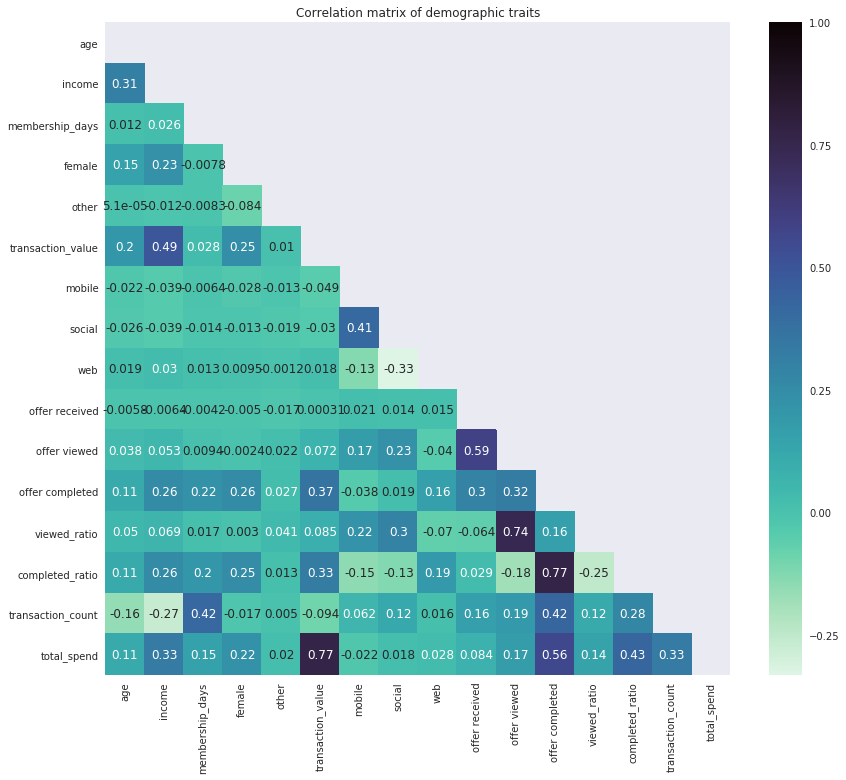

In [86]:
# but first, some exploratory stats about our demographic data
corr_cols = demographic.columns.tolist()[1:]
sns.set(rc={'figure.figsize':(14, 12)})
# matrix
corr = demographic[corr_cols].corr()
# create mask to hide duplicate values
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask,
            annot = True, cmap = 'mako_r').\
set_title('Correlation matrix of demographic traits');

There are a few obvious relationships in here: 
* Total spend and spend per transaction are very strongly correlated
* The number of offers received and viewed is strongly correlated, although subsequent completion is a weaker relationship
* Higher spenders per transaction and in total are likely to complete more offers

However, there are also some interesting behavioural / demographic traits:
* Age and income are somewhat correlated, at 0.31, and income and spend per transaction at 0.49
* People with lower incomes have higher transaction counts while those with higher incomes spend more per transaction.
* People who have been members for longer tend to make more transactions, which in turn leads them to complete more offers
* Women seem to spend slightly more in total and complete more offers

In [23]:
# now let's zoom in on people likely to be incentivised according to our logic
incentivised = demographic[(demographic['transaction_value'] < 20) &
                          (demographic['viewed_ratio'] > 0) &
                          (demographic['completed_ratio'] > 0) &
                          (demographic['completed_ratio'] < 1)]

In [24]:
# create 'non-incentivised' df
incentivised_ids = incentivised['person'].tolist()
non_incentivised = demographic[demographic['person'].isin(incentivised_ids) == False]

In [25]:
# printing some stats
print(f'Total number of customers in data: {demographic.shape[0]}')
print(f'Number of customers likely to be incentivised and active: {incentivised.shape[0]}')
print(f'As share  of total: {round(incentivised.shape[0] / demographic.shape[0] * 100)}%')

Total number of customers in data: 17000
Number of customers likely to be incentivised and active: 5624
As share  of total: 33%


In [26]:
# Now let's investigate how the two differ demographically
incentivised_means = []
non_incentivised_means = []
for col in corr_cols:
    incentivised_means.append(round(incentivised[col].mean(), 2))
    non_incentivised_means.append(round(non_incentivised[col].mean(), 2))
    
mean_diff_df = pd.DataFrame([incentivised_means, non_incentivised_means],
            columns = corr_cols, 
             index = ['mean_incentivised', 'mean_non_incentivised']).transpose()

mean_diff_df.drop('completed_ratio', inplace = True)

mean_diff_df['mean_difference'] = mean_diff_df['mean_incentivised'] - mean_diff_df['mean_non_incentivised']

In [27]:
# doing the same but with median to check for outliers
incentivised_medians = []
non_incentivised_medians = []
for col in corr_cols:
    incentivised_medians.append(round(incentivised[col].median(), 2))
    non_incentivised_medians.append(round(non_incentivised[col].median(), 2))
    
median_diff_df = pd.DataFrame([incentivised_medians, non_incentivised_medians],
            columns = corr_cols, 
             index = ['median_incentivised', 'median_non_incentivised']).transpose()

median_diff_df.drop('completed_ratio', inplace = True)

median_diff_df['median_difference'] = median_diff_df['median_incentivised'] - median_diff_df['median_non_incentivised']

In [28]:
diff_df = pd.concat([mean_diff_df, median_diff_df], axis = 1)

In [29]:
mean_diff_df['pct_difference'] = round(mean_diff_df['mean_difference'] / mean_diff_df['mean_incentivised'] * 100, 2)
mean_diff_df.sort_values(by = 'pct_difference')
median_diff_df['pct_difference2'] = round(median_diff_df['median_difference'] / median_diff_df['median_incentivised'] * 100, 2)
median_diff_df.drop(['female', 'other'], axis = 0, inplace = True)
mean_diff_df.drop('other', axis = 0, inplace = True)

In [30]:
diff_df = pd.concat([mean_diff_df, median_diff_df], axis = 1, sort = False)
diff_df_sorted = diff_df.sort_values(by = 'pct_difference', ascending = False)

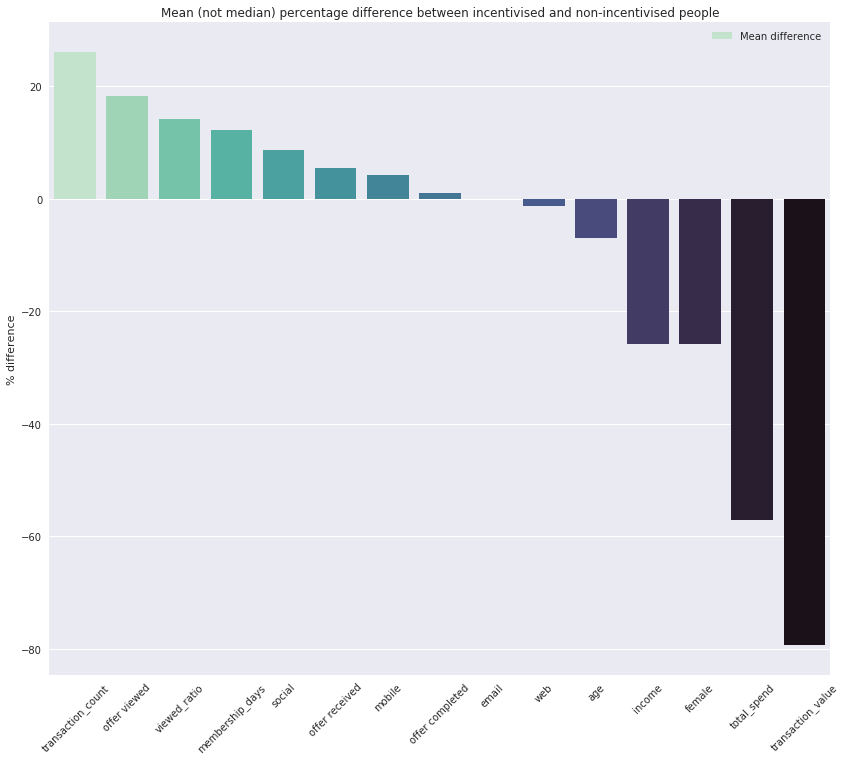

In [87]:
# plotting
xlabels = diff_df_sorted.index.tolist()
sns.barplot(xlabels, diff_df_sorted['pct_difference'], palette = 'mako_r', label = 'Mean difference')
plt.xticks(rotation = 45)
plt.ylabel('% difference')
plt.title('Mean (not median) percentage difference between incentivised and non-incentivised people')
plt.legend();

A couple of findings here:
* Incentivised people tend to make a lot more transactions
* They have been members for quite a lot longer
* They also tend to view more offers.

These findings hint that they are more active and loyal members, so that our three criteria for identifying people overall likely to be incentivised make sense.

Conversely, people unlikely to be incentivised tend to have high incomes and spend more per transaction and in total, and, correlated with their high income is that they are older. 

Additionally, incentivised people are more likely to be contacted through social and mobile, which might hint at the fact that they are younger, which in turn means they might have slightly lower incomes. We'll keep an eye on the channels through which people are targeted going forward.

In [32]:
# printing the whole df
diff_df

,mean_incentivised,mean_non_incentivised,mean_difference,pct_difference,median_incentivised,median_non_incentivised,median_difference,pct_difference2
age,51.96,55.60,-3.64,-7.01,52.00,56.00,-4.00,-7.69
income,55797.68,70174.22,-14376.54,-25.77,56000.00,71000.00,-15000.00,-26.79
membership_days,564.70,495.59,69.11,12.24,391.00,353.00,38.00,9.72
female,0.31,0.39,-0.08,-25.81,NaN,NaN,NaN,NaN
transaction_value,8.98,16.10,-7.12,-79.29,7.33,15.31,-7.98,-108.87
email,1.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00
mobile,0.94,0.90,0.04,4.26,1.00,1.00,0.00,0.00
social,0.69,0.63,0.06,8.70,0.70,0.67,0.03,4.29
web,0.80,0.81,-0.01,-1.25,0.82,0.82,0.00,0.00
offer received,4.66,4.40,0.26,5.58,5.00,4.00,1.00,20.00


## Conclusions
- The membership group can be split between people who are likely to be incentivised by being sent promotions (i.e. they don't spend so much that they would, on average, tend to complete even the hardest offers; they view their offers; and they complete offers).
- The incentivised group is about one-third of the total membership group. 
- Between the two groups, there are some clear differences and key points. 'Incentivised' people
    - are on average 4 years younger
    - have about \$15,000 less income
    - have been members for 2 months longer
    - spend on average $7.5 less per transaction
    - make about 3 transactions more in the same timeframe
    
- In other words, people who are likely to be incentivised by offers are younger, have less income and spend less per transaction, but tend to be more loyal members and make more transactions, which ultimately means they have higher median (but not mean) spend.

# Step 3: Demographics per offer type

### Approach
* Focus only on people we identified as being likely to be incentivised by offers / engage with the programme according to our logic. Create incentivised_offers dataframe
* See if we can spot any patterns about engagement in general (viewed and completion ratios)
* Segment further by successful customer journeys and see how successful customers differ per offer from everyone else
* Try to use the profiles of successful current customers per offer to identify new customers.

In [33]:
# create incentivised_offers
incentivised_offers = offers.merge(incentivised, how = 'inner', on = 'person')

In [34]:
# to ensure we can adequately group by and calculate statistics, need
# dummies for channels and offer_type
channels_dummies = pd.get_dummies(incentivised_offers['channels'].\
                                  apply(pd.Series).stack()).sum(level=0)

In [35]:
offer_type_dummies = pd.get_dummies(incentivised_offers['offer_type'])

In [36]:
incentivised_offers = pd.concat([incentivised_offers, channels_dummies,
                                offer_type_dummies], axis = 1)

First, we can group by the specific offers and see whether there are important differences in completion ratio as well as the demographic characteristics: age, income, membership duration, gender, transaction value, count, and total spend.

In [37]:
groupby_cols = ['completed_ratio', 'age', 'income', 'membership_days',
               'female', 'transaction_value', 'transaction_count',
               'total_spend', 'offer_type_full', 'offer received']

incentivised_offers[groupby_cols].groupby('offer_type_full').mean()

,completed_ratio,age,income,membership_days,female,transaction_value,transaction_count,total_spend,offer received
offer_type_full,,,,,,,,,
bogo_diff10_dur5_rew10,0.526489,52.056073,55919.742028,591.230533,0.321648,9.583416,10.473667,86.960698,4.885784
bogo_diff10_dur7_rew10,0.531725,52.000923,55808.310249,569.737645,0.331509,9.449563,10.687065,88.996041,4.826534
bogo_diff5_dur5_rew5,0.522288,52.080503,55686.642717,559.345550,0.291643,8.841212,10.072447,78.506142,4.839989
bogo_diff5_dur7_rew5,0.543677,53.337688,56148.269105,570.238911,0.315820,9.545052,9.542547,80.418572,4.853036
disc_diff10_dur10_rew2,0.534199,51.402951,55624.865529,574.279188,0.290838,8.437173,10.909031,79.066366,4.867277
disc_diff10_dur7_rew2,0.549015,53.011228,57411.090742,573.609677,0.319153,9.956298,9.759879,83.783635,4.876008
disc_diff20_dur10_rew5,0.542866,53.357542,57565.176909,553.051226,0.329973,10.472160,9.322616,85.780234,4.868392
disc_diff7_dur7_rew3,0.530739,51.028362,54792.804896,540.193619,0.286762,8.261515,10.396887,76.465393,4.817960
info_diff0_dur3_rew0,0.486374,52.060527,55979.450775,572.529332,0.340828,9.994871,10.128656,93.035964,4.824345


At this level, there aren't obvious demographic differences in completion ratios or demographic characteristics. The only noticeable thing is that people who spend more complete the more difficult (expensive) offers.

Next, we'll look into the highest-engaged people per offer. We'll investigate the people in the top quartile of completion ratios for every offer and see how they differ from the general population.

In [38]:
offer_names = incentivised_offers['offer_type_full'].unique().tolist()
# get rid of informational offers
offer_names = sorted(offer_names)[:-2]
# use IQR check whether the distribution of completion ratios varies by offer
from scipy import stats
for offer in offer_names: 
    print(f'IQR for offer {offer}', 
          stats.iqr(incentivised_offers[incentivised_offers['offer_type_full'] == offer]['completed_ratio']))

IQR for offer bogo_diff10_dur5_rew10 0.333333333333
IQR for offer bogo_diff10_dur7_rew10 0.416666666667
IQR for offer bogo_diff5_dur5_rew5 0.333333333333
IQR for offer bogo_diff5_dur7_rew5 0.35
IQR for offer disc_diff10_dur10_rew2 0.333333333333
IQR for offer disc_diff10_dur7_rew2 0.35
IQR for offer disc_diff20_dur10_rew5 0.416666666667
IQR for offer disc_diff7_dur7_rew3 0.333333333333


In [39]:
# analyse top quartiles
diffs = {}
# characteristics to analyse
characteristics = ['age', 'income', 'membership_days', 'female',
                  'transaction_value','offer received', 'offer viewed',
                   'offer completed', 'viewed_ratio',
                   'transaction_count', 'total_spend']

for offer in offer_names:
    offer_rows = incentivised_offers\
    [incentivised_offers['offer_type_full'] == offer]
    
    top_quartile_thresh = offer_rows['completed_ratio'].describe()[6]
    # subset and group by to get person-level data
    top_quartile = offer_rows[offer_rows['completed_ratio'] >= top_quartile_thresh].\
    groupby('person', as_index = False).mean()
    
    # analyse differences compared to rest of overall population
    rest = demographic[demographic['person'].isin(top_quartile['person'].tolist()) == False]
    diffs_list = {}
    for col in characteristics:
        diffs_list[col] = top_quartile[col].mean() - rest[col].mean()
        
        diffs[offer] = diffs_list

In [40]:
# creating diffs of mean differences (top quartile versus rest per offer)
mean_diffs = pd.DataFrame(diffs)

In [41]:
mean_diffs

,bogo_diff10_dur5_rew10,bogo_diff10_dur7_rew10,bogo_diff5_dur5_rew5,bogo_diff5_dur7_rew5,disc_diff10_dur10_rew2,disc_diff10_dur7_rew2,disc_diff20_dur10_rew5,disc_diff7_dur7_rew3
age,-1.622444,-0.027330,-0.600489,-0.113063,-2.141142,0.274447,0.679169,-1.930740
female,0.029320,0.108099,-0.014656,0.036666,-0.000155,0.031304,0.065557,0.017553
income,-9206.401841,-8668.852998,-9145.604818,-8437.705822,-9010.935426,-6835.741010,-7183.066261,-9868.203414
membership_days,106.517610,81.269268,101.890535,124.562965,118.704662,96.195076,34.341115,64.039033
offer completed,1.155107,1.629519,1.149241,1.649132,1.177059,1.648089,1.596422,1.122062
offer received,0.373516,0.523167,0.315347,0.602925,0.360231,0.576319,0.592785,0.263067
offer viewed,0.787258,1.197318,0.779662,1.217896,0.801436,1.217504,1.167516,0.743882
total_spend,11.614391,34.043883,8.406873,21.666485,7.360238,23.961084,22.675756,3.939712
transaction_count,3.398123,4.194491,3.266851,3.205556,3.934314,3.141039,2.417270,3.573944
transaction_value,-2.162336,-1.138932,-2.524598,-1.185721,-2.942058,-0.751966,-0.397158,-3.090362


* This is still not hugely informative. The more difficult offers tend to get completed by relatively wealthier people (the gap between their income and that of the rest is smaller), which in turn correlates with having been members for shorter, etc.

* Let's dig deeper - let's see the profiles of people who completed a full journey through the offer: from received, to viewed, to completed.

In [ ]:
# we want a (very sparse) dataframe recording for every offer-related
# event which offer someone received, viewed, and completed
# once we group this dataframe, we can see for every person 
# how many of each offer they received, viewed, completed
# then we can see which people complete the whole funnel per offer type

In [42]:
# dummies for events
offers = pd.concat([offers, pd.get_dummies(offers['event'])], axis = 1)

In [43]:
# also dummies for the corresponding offers
offer_events_outcomes_dummies = pd.concat([pd.get_dummies(offers['event']), 
           pd.get_dummies(offers['offer_type_full'])], axis = 1)

In [44]:
# get rid of info offers
offer_events_outcomes_dummies = offer_events_outcomes_dummies[['offer received', 'offer viewed', 'offer completed',
       'bogo_diff10_dur5_rew10', 'bogo_diff10_dur7_rew10',
       'bogo_diff5_dur5_rew5', 'bogo_diff5_dur7_rew5',
       'disc_diff10_dur10_rew2', 'disc_diff10_dur7_rew2',
       'disc_diff20_dur10_rew5', 'disc_diff7_dur7_rew3']]

In [45]:
# creating separate dfs per event category
received = offer_events_outcomes_dummies\
[offer_events_outcomes_dummies['offer received'] == 1]
viewed = offer_events_outcomes_dummies\
[offer_events_outcomes_dummies['offer viewed'] == 1]
completed = offer_events_outcomes_dummies\
[offer_events_outcomes_dummies['offer completed'] == 1]

With these dataframes in place, we can create a new master dataframe where we can see for every combination of a event type (received, viewed, and completed) and every offer type (minus informational offers because they cannot be completed) what happened. This will be crucial to documenting, per customer, whether they complete full customer journeys.

In [46]:
success = []
for index, row in received.iterrows():
    for col in received.columns.tolist()[3:]:
        if row[col] != 0:
            success.append([index, {col+'_received' : 1}])
        
received_new = pd.DataFrame(dict(success)).transpose()

In [47]:
success_2 = []
for index, row in viewed.iterrows():
    for col in viewed.columns.tolist()[3:]:
        if row[col] != 0:
            success_2.append([index, {col+'_viewed' : 1}])
            
viewed_new = pd.DataFrame(dict(success_2)).transpose()

In [48]:
success_3 = []
for index, row in completed.iterrows():
    for col in completed.columns.tolist()[3:]:
        if row[col] != 0:
            success_3.append([index, {col + '_completed' : 1}])
            
completed_new = pd.DataFrame(dict(success_3)).transpose()

In [49]:
# creating new master
new_master = pd.concat([received_new, viewed_new, completed_new], axis = 1)

In [50]:
# adding in person ids
new_master = pd.concat([offers['person'], new_master], axis = 1)

In [51]:
# grouping by person and summing events
new_master_grouped = new_master.groupby('person', as_index = False).sum()

Now we can create the number of customer journeys

We will divide the sum of received + viewed + completed by 3 so that a 1 in each column will result in one complete customer journey. Also need to round down, so that e.g. a sum of 5 results in 1, not 2, customer journeys. Finally, none of the individual values can be 0 (so that e.g. 2 received, 1 viewed but 0 completed is not counted as a completed offer). 

This works well in practice - I did not see any false positives while scanning the first 500 rows of the new data

In [52]:
import math
success_journeys = lambda x: math.floor(sum(x) / 3) if (x[0] != 0 and x[1] != 0 and x[2] != 0) else 0
try_1 = new_master_grouped[['person', 'bogo_diff5_dur5_rew5_received', 'bogo_diff5_dur5_rew5_viewed',
                  'bogo_diff5_dur5_rew5_completed']]

try_1['success_journeys'] = try_1.iloc[:, 1:].apply(success_journeys, axis = 1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [53]:
# calculating success journeys
success_journeys = lambda x: math.floor(sum(x) / 3) if (x[0] != 0 and x[1] != 0 and x[2] != 0) else 0

for offer in offer_names:
    subset = new_master_grouped[['person', f'{offer}_received', f'{offer}_viewed', f'{offer}_completed']]
    offer_success_journeys = subset.iloc[:, 1:].apply(success_journeys, axis = 1)
    # reassign to original df
    new_master_grouped[f'{offer}_success_journeys'] = offer_success_journeys

In [54]:
success_df = pd.concat([new_master_grouped['person'], new_master_grouped.iloc[:, 25:]], axis = 1)

In [55]:
# now we can see offers had the highest shares of successful customer journeys
plot_data = []
for col in success_df.columns[1:]:
    plot_data.append([col[:-17], success_df[col].mean()])

In [56]:
from operator import itemgetter
plot_data = sorted(plot_data, key=itemgetter(1), reverse = True)

We can now do more analysis. For example, we can see which offers had the highest shares of successful customer journeys.

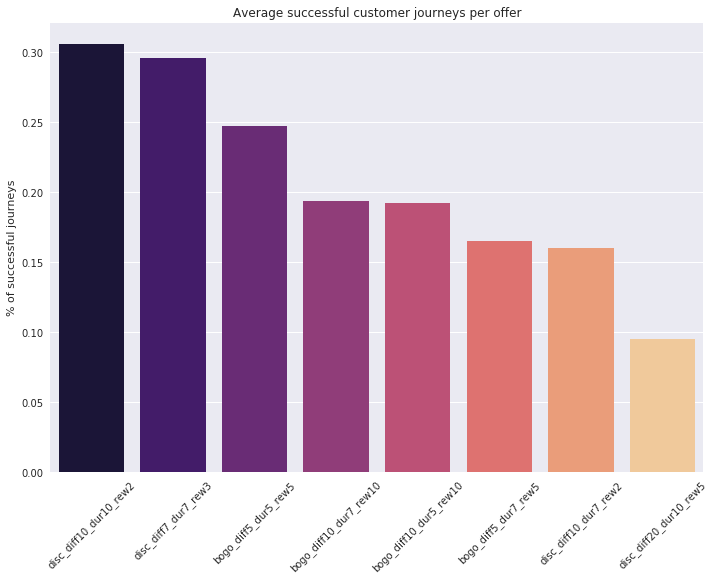

In [57]:
sns.barplot([x[0] for x in plot_data], 
            [x[1] for x in plot_data], palette = 'magma')
sns.set(rc={'figure.figsize':(14, 12)})
plt.xticks(rotation = 45)
plt.ylabel('% of successful journeys')
plt.title('Average successful customer journeys per offer')
plt.legend();

We can now add the demographic data back in and build reports about successful customers for each offer.

In [58]:
# add in demographic data
success_master = success_df.merge(demographic, how = 'inner', on = 'person')

In [59]:
# getting rid of email as a characteristic because everyone was target using email (so will be no differences)
demographic_characteristics = ['age', 'income', 'membership_days', 'female', 'transaction_value', 
                               'mobile', 'social', 'web', 'viewed_ratio',
                               'transaction_count', 'total_spend']

# 'reporting' function: per offer, generate a report of how successful customers are different to other customers
def build_report(offer: str, characteristics = demographic_characteristics, plot = True):
    """Generates a dataframe and a difference chart for a selected offer and demographic characteristics

    Parameters
    ----------
    offer: str
        a full offer_type: one of 
      'bogo_diff10_dur5_rew10'
     'bogo_diff10_dur7_rew10',
     'bogo_diff5_dur5_rew5',
     'bogo_diff5_dur7_rew5',
     'disc_diff10_dur10_rew2',
     'disc_diff10_dur7_rew2',
     'disc_diff20_dur10_rew5',
     'disc_diff7_dur7_rew3'
    characteristics: list
        one or multiple demographic characteristics. Full list by default
    plot: bool
        whether to generate a plot

    Returns
    ---------
    a pandas dataframe of the successful customers' mean characteristics vs general population
    a difference plot"""

    # subset successful customers
    successful_customers = success_master[success_master[offer+'_success_journeys'] >= 1]

    # initialise demographic 'report' dictionary
    success_report = {}

    # loop through characteristics 
    for col in characteristics:
        success_report[col] = successful_customers[col].mean()

    # turn into df
    success_df = pd.DataFrame(success_report, index = ['mean_success']).transpose()

    # subset everyone else
    everyone_else = demographic[demographic['person'].isin(successful_customers['person']) == False]

    # initialise 'everyone else report'
    everyone_else_report = {}

    # loop through characteristics
    for col in characteristics:
        everyone_else_report[col] = everyone_else[col].mean()

    # turn into df
    everyone_else_df = pd.DataFrame(everyone_else_report, index = ['mean_rest']).transpose()

    # merge dfs
    joint_df = pd.concat([success_df, everyone_else_df], axis = 1)

    # create diff columns
    joint_df['diff'] = joint_df['mean_success'] - joint_df['mean_rest']
    joint_df['pct_diff'] = joint_df['diff'] / joint_df['mean_success'] * 100
    
    # sorting df by pct diff
    joint_df = joint_df.sort_values(by = 'pct_diff', ascending = False)

    # optional plot
    if plot: 
        sns.barplot(joint_df.index, 
                    joint_df['pct_diff'], 
                    palette = 'mako')
        sns.set(rc={'figure.figsize':(14, 12)})
        plt.xticks(rotation = 45)
        plt.ylabel('% difference: successful customers vs rest')
        plt.title(f'Differences between successful customers of offer {offer} and rest')
        plt.show();
    
    return joint_df

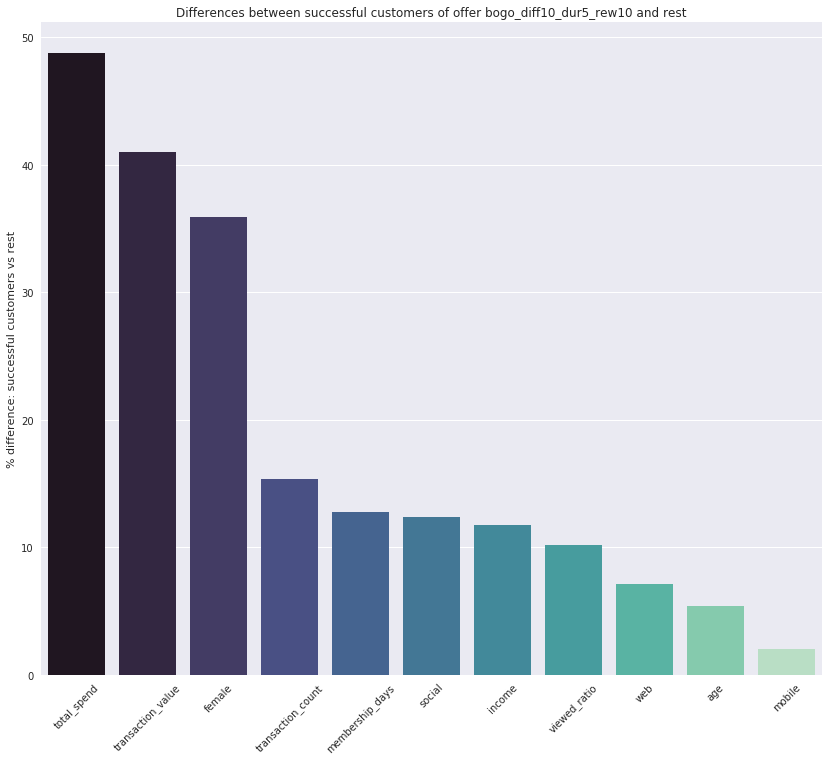

In [60]:
# example report
diff_df = build_report('bogo_diff10_dur5_rew10', plot = True)

We can also summarise the demographic differences between successful customers for each offer. The below will print the differences between successful customers for an offer and the rest of the population.

In [61]:
# going through differences per offer
for offer in offer_names:
    print(offer)
    print(build_report(offer, plot = False)['pct_diff'])
    print('\n')

bogo_diff10_dur5_rew10
total_spend          48.743762
transaction_value    41.014247
female               35.921462
transaction_count    15.326548
membership_days      12.752400
social               12.391859
income               11.765176
viewed_ratio         10.158988
web                   7.107102
age                   5.391269
mobile                2.030101
Name: pct_diff, dtype: float64


bogo_diff10_dur7_rew10
total_spend          49.751529
transaction_value    38.982765
female               33.343249
transaction_count    19.893601
social               12.963680
viewed_ratio         11.037498
membership_days      10.244561
income                9.674465
age                   3.887275
mobile                1.724020
web                 -36.547575
Name: pct_diff, dtype: float64


bogo_diff5_dur5_rew5
total_spend          38.579823
transaction_value    26.223414
female               22.930333
transaction_count    21.987391
membership_days      15.187130
social               14.691561

### A few observations
* Successful customers (i.e. those that completed at least one full journey from received -> viewed -> completed) are, unsurprisingly, more active customers in that they make more transactions and spend more both per transaction and in total. This is not surprising. However, it is still worth looking at the extent of the gap. For example, lower-difficulty offers are more likely to be completed by people whose income and spending is lower than that of the rest of the population.

* The most interesting characteristics are the channels through which customers are targeted. (We disregard email because everyone is targeted through email.) For example, the most 'difficult' offer requiring \\$20 in spend, tends to be completed by customers who tend to be targeted more through the web and much less through social and mobile channels. This in turn is likely linked to their higher age - the age delta for this category of successful customer is 5 years, the second-highest of any category, and, in turn, higher income as well. 



The user can use this information and the individual reporting function above to select characteristics, per offer, that they think are relevant to customer success for an offer. They can then use the below function to try to identify new customers.

In [74]:
def find_new_customers(offer: str, granularity: float = 0.05, characteristics: list = ['age', 'income', 'social']):
    """
    Identify potential new customers who match the specified profile who have not yet been targeted with this offer
    
    Parameters
     ----------
    offer: str
        a full offer_type: one of 
      'bogo_diff10_dur5_rew10'
     'bogo_diff10_dur7_rew10',
     'bogo_diff5_dur5_rew5',
     'bogo_diff5_dur7_rew5',
     'disc_diff10_dur10_rew2',
     'disc_diff10_dur7_rew2',
     'disc_diff20_dur10_rew5',
     'disc_diff7_dur7_rew3'
    granularity: float
        percentage of margin around mean characteristic value of successful customers (e.g. age +- 2%)
    characteristics: list
        up to three demographic characteristics. Age, income, and social by default
        
    Returns
    ----------
    list of ids of likely new customers
    """
    # identify successful customers for this offer
    success_df = success_master[success_master[offer+'_success_journeys'] >= 1]
    success_ids = success_df['person']
    
    # find their profile on selected characteristics
    profile = []
    
    for characteristic in characteristics:
        profile.append([characteristic, success_df[characteristic].mean()])
        
    print(f'Successful customer profile for offer {offer}:')    
    for item in profile:
        print(f'Average {item[0]}: {round(item[1], 1)}')
        
    print('\n')
    print(f'Searching for customers fitting this profile with a {granularity * 100}% margin of error...')
    print('\n')
    
    # subset all other customers in demographic df
    everyone_else_df = demographic[demographic['person'].isin(success_ids) == False]
    
    # filter based on specified characteristics and granularity
    if len(profile) == 1:
        subset = everyone_else_df[
            (everyone_else_df[profile[0][0]].between(round(profile[0][1] * (1 - granularity), 0), round(profile[0][1] * (1 + granularity), 0)))
        ]
    
    elif len(profile) == 2:
        subset = everyone_else_df[
            (everyone_else_df[profile[0][0]].between(round(profile[0][1] * (1 - granularity), 0), round(profile[0][1] * (1 + granularity), 0))) &
        (everyone_else_df[profile[1][0]].between(round(profile[1][1] * (1 - granularity), 0), round(profile[1][1] * (1 + granularity), 0)))
        ]
    
    elif len(profile) == 3:
        subset = everyone_else_df[
            (everyone_else_df[profile[0][0]].between(round(profile[0][1] * (1 - granularity), 0), round(profile[0][1] * (1 + granularity), 0))) &
        (everyone_else_df[profile[1][0]].between(round(profile[1][1] * (1 - granularity), 0), round(profile[1][1] * (1 + granularity), 0))) &
        (everyone_else_df[profile[2][0]].between(round(profile[2][1] * (1 - granularity), 0), round(profile[2][1] * (1 + granularity), 0)))
        ]
    
    if len(subset) != 0:
        print(f'{subset.shape[0]} new potential customers found! Here are their ids...')
    
        return subset['person'].values.tolist()
    else: print('No new customers found! Please change your search parameters.')

For example, this is what it might look like for the offer Buy one Get one, difficulty = 10, duration = 5 days, reward = 10

In [77]:
find_new_customers('bogo_diff10_dur5_rew10', granularity = 0.1, characteristics = ['total_spend',
                                                                                  'membership_days'
                                                                                  ])

Successful customer profile for offer bogo_diff10_dur5_rew10:
Average total_spend: 179.8
Average membership_days: 580.1


Searching for customers fitting this profile with a 10.0% margin of error...


92 new potential customers found! Here are their ids...


['050cdb2d5b4b4bb3b1c612e17e0e8c1b',
 '062964a129f64110a3919595cd731141',
 '06546973bb7942f9bac814496d70678c',
 '0a73c45eda784402957f033343dabeed',
 '0de7e5bda8e84fcfa7c67bf87170c88e',
 '10cbaa18d359457d899edf285d85a9b4',
 '121a62fa7f5349ad90d97dad47e7194d',
 '1997b4c538804d42bac6d58c32ec26b4',
 '21fa118bc6b84650976fed5df7d3040c',
 '24ab1d9c55254e8eb9d263f3bf3d98fc',
 '264f876fe2ff4fbfb9e417dd7c140e96',
 '26e8ef90d9d64c919ebbe964781c122f',
 '2f3d4b6c868e4f3cad94f81fe2da536f',
 '312a522266084c29b1b92c1a35f6de82',
 '3347e6cc276f45d6b7a3b18e955f7bb9',
 '3587049edaf84b8f963ecdbb65beb24e',
 '37052ed3ff944ac291e47696cffb8efd',
 '371d6b3a983547709252bbbcbedda147',
 '375b452ee0b64a4fbac92e61670f961d',
 '39dc79d51dd54a5189a94fafd69c0125',
 '3ab94c67c9324d37aaf478e61c028438',
 '3d2d54ddebaf4d39ae02b96ff65ec727',
 '3d6838fcab094b999a032af69d635f89',
 '3e83066be8ad466c9e8a8ca4476e9a52',
 '40399df768594afaa13aaca0b273608d',
 '4202b82c9a504e048d7e5f20fe687c6a',
 '42f0d273d2914b0192bd37a37888df36',
 

## Final thoughts
I enjoyed doing a project that is purely about using business logic rather than machine learning, because it makes it much easier to communicate ideas and methods to a non-technical audience. I also feel that these methods were quite effective at segmenting the customer base. Additionally, the final two functions are easy to use to build a report about what the demographics of successful customers per offer are and to suggest new customers.

However, the lack of machine learning / modelling also means that the project in its current state has its shortcomings. Most importantly, there isn't currently a rigourous way to verify which features are the best predictors for whether a customer will complete an offer, and although there is logic behind the second function that identifies new people to target with an offer, there is no quantitative metric to verify how accurate those suggestions are.

So some degree of machine learning in feature selection and validating recommendations for targeting new people would make the project better.

Also, in a next iteration, I would develop a web app to make interacting with the report-building and identifying new customers more user-friendly.